In [27]:
from scripts.parsers import parse_sequences
import xml.etree.ElementTree as ET
from math import cos, sin, inf
import numpy as np
import itertools
import cv2
import c3d

In [18]:
def video_frame_iterator(video_path, frames_n=inf):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Error: Could not open video.")
        
    iteration = 0
    while True and iteration < frames_n:
        ret, frame = cap.read()
        if not ret:
            break
            
        iteration += 1
        yield iteration, frame
        
    cap.release()

In [48]:
class TsaiCameraCalibrator:
    def __init__(self, calibraton_file_path, markers_number):
        self.markers_number = markers_number

        tree = ET.parse(calibraton_file_path)
        root = tree.getroot()
        geometry = root.find('Geometry')
        intrinsic = root.find('Intrinsic')
        extrinsic = root.find('Extrinsic')
        
        self.img_width = int(geometry.get('width'))
        self.img_height = int(geometry.get('height'))
        
        self.focal_length = float(intrinsic.get('focal'))
        self.k = float(intrinsic.get('kappa1'))
        self.cx = float(intrinsic.get('cx'))
        self.cy = float(intrinsic.get('cy'))
        self.sx = float(intrinsic.get('sx'))
        
        tx = float(extrinsic.get('tx'))
        ty = float(extrinsic.get('ty'))
        tz = float(extrinsic.get('tz'))
        
        rx = float(extrinsic.get('rx'))
        ry = float(extrinsic.get('ry'))
        rz = float(extrinsic.get('rz'))
        
        self.dx = float(geometry.get('dx'))
        self.dy = float(geometry.get('dy'))
        dpx = float(geometry.get('dpx'))
        dpy = float(geometry.get('dpy'))

        self.R = self._calculate_r_array(rx, ry, rz)
        self.T = np.array([tx, ty, tz])

    def _calculate_r_array(self, rx, ry, rz):
        r1 = cos(ry) * cos(rz)
        r2 = cos(rz) * sin(rx) * sin(ry) - cos(rx) * sin(rz)
        r3 = sin(rx) * sin(rz) + cos(rx) * cos(rz) * sin(ry)
        r4 = cos(ry) * sin(rz)
        r5 = sin(rx) * sin(ry) * sin(rz) + cos(rx) * cos(rz)
        r6 = cos(rx) * sin(ry) * sin(rz) - cos(rz) * sin(rx)
        r7 = - sin(ry)
        r8 = cos(ry) * sin(rx)
        r9 = cos(rx) * cos(ry)
        
        return np.array([[r1, r2, r3], [r4, r5, r6], [r7, r8, r9]])
        
    def calibrate_image_points(self, mocap_points):
        coordinates_3d = (self.R @ mocap_points.T + np.array([self.T for _ in range(self.markers_number)]).T)
        xi, yi, zi = coordinates_3d[0], coordinates_3d[1], coordinates_3d[2]
        xu = self.focal_length * xi/zi
        yu = self.focal_length * yi/zi
        r = np.sqrt(xu ** 2 + yu ** 2)
        xd = xu * (1 - self.k * r ** 2)
        yd = yu * (1 - self.k * r ** 2)
        xf = (self.sx * xd)/self.dx + self.cx
        yf = yd/self.dy + self.cy
        
        if not np.all((xf >= 0) & (xf <= self.img_width)):
            raise ValueError(f"Calculated x-coordinates outside of the limit!")

        if not np.all((yf >= 0) & (yf <= self.img_height)):
            raise ValueError(f"Calculated y-coordinates outside of the limit!")
            
        points = list(zip(np.round(xf).astype(int), np.round(yf).astype(int)))
        return points


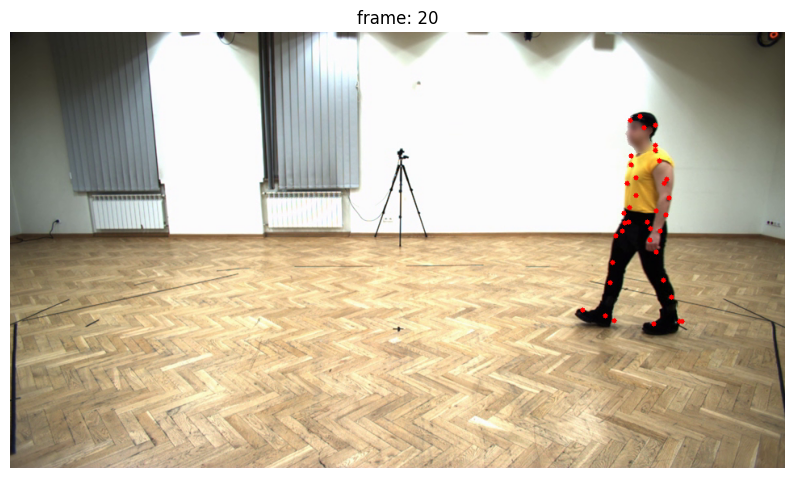

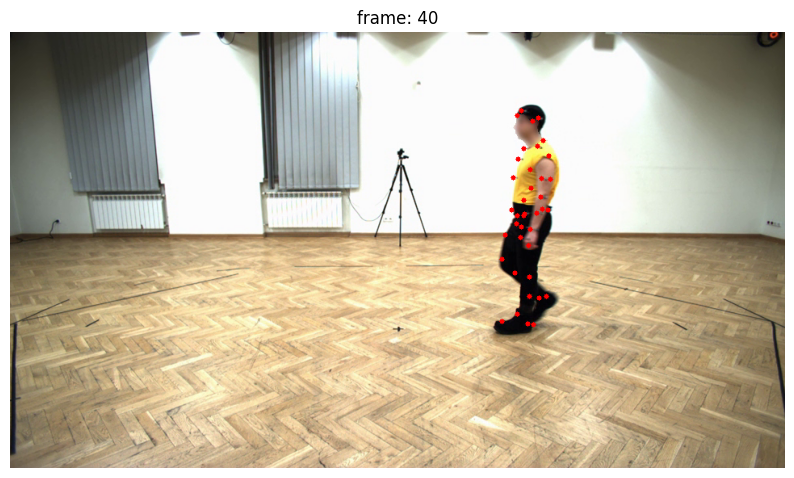

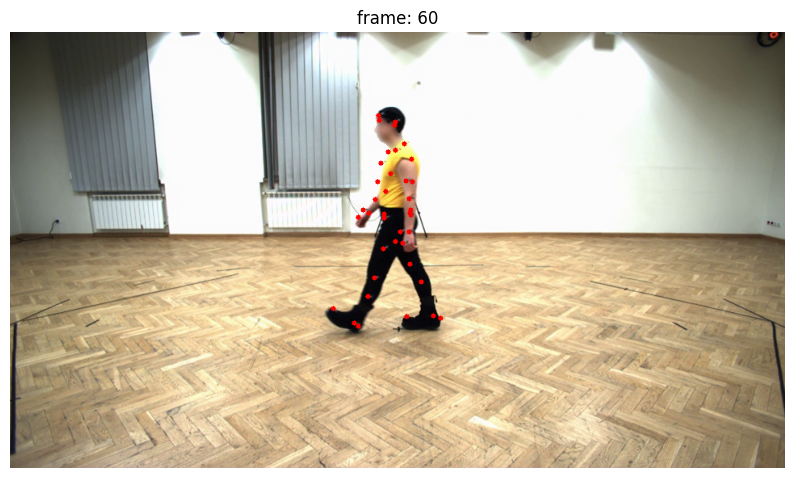

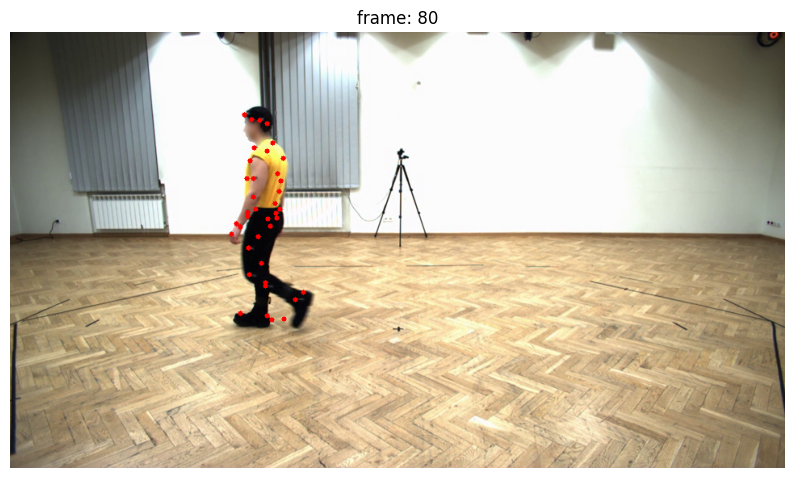

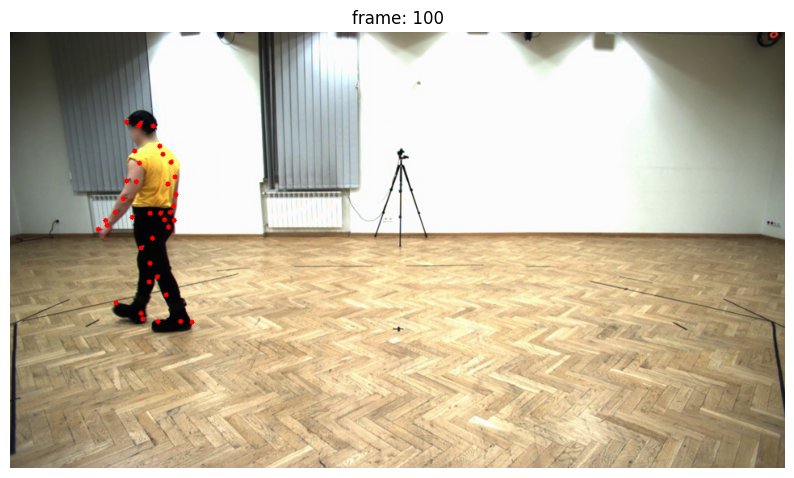

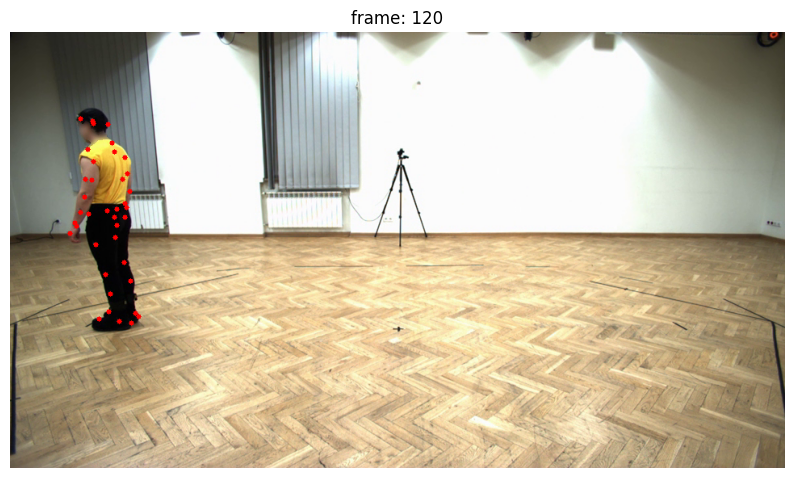

In [88]:
import matplotlib.pyplot as plt

def visualize_frame_from_video(sequence_key, camera_number, frames_number=inf):
    markers_number = 39
    dot_color = (0, 0, 255)
    dot_radius = 3
    dot_thickness = -1 # for solid circle
    
    file_path = 'gait3d\\ListOfSequences.txt'
    sequence_info = parse_sequences(file_path)[sequence_key]
    avi_file_name = f"c{camera_number}_{(4 - len(str(sequence_info['start_frame']))) * '0' + str(sequence_info['start_frame'])}"
    avi_seq_path = f".\\gait3d\\Sequences\\{sequence_key}\\Images\\{avi_file_name}.avi"
    calibraton_xml_file_path = f"gait3d\\Sequences\\{sequence_key}\\Calibration\\c{camera_number}.xml"    
    mocap_c3d_path = f'gait3d\\Sequences\\{sequence_key}\\MoCap\\{sequence_key}.c3d'

    calibrator = TsaiCameraCalibrator(calibraton_xml_file_path, markers_number)

    video_frames = video_frame_iterator(avi_seq_path, min(frames_number, sequence_info['number_of_frames']))

    with open(mocap_c3d_path, 'rb') as handle:
        reader = c3d.Reader(handle)
        start_frame = sequence_info['start_frame'] * 4 - 1 # try add or subtract 1 or 2 frames (4 mocap frames for one vid frame)
        step = 4 # 100 fps mockup vs 25 fps video
        mocap_frames = itertools.islice(reader.read_frames(), start_frame, None, 4)

        for (i, vid_frame), mocap_frame in zip(video_frames, mocap_frames):
            mocap_frame_markers = mocap_frame[1][:markers_number, :3]
            image_markers = calibrator.calibrate_image_points(mocap_frame_markers)
            height, width, _ = vid_frame.shape

            for marker in image_markers:
                dot_center = (marker[0], marker[1])
                cv2.circle(vid_frame, dot_center, dot_radius, dot_color, dot_thickness)
                vid_frame_rgb = cv2.cvtColor(vid_frame, cv2.COLOR_BGR2RGB)

            if not i%20:
                plt.figure(figsize=(10, 6))
                plt.imshow(vid_frame_rgb)
                plt.axis('off')
                plt.title(f'frame: {i}')
                plt.show()

visualize_frame_from_video('p7s1', 1)

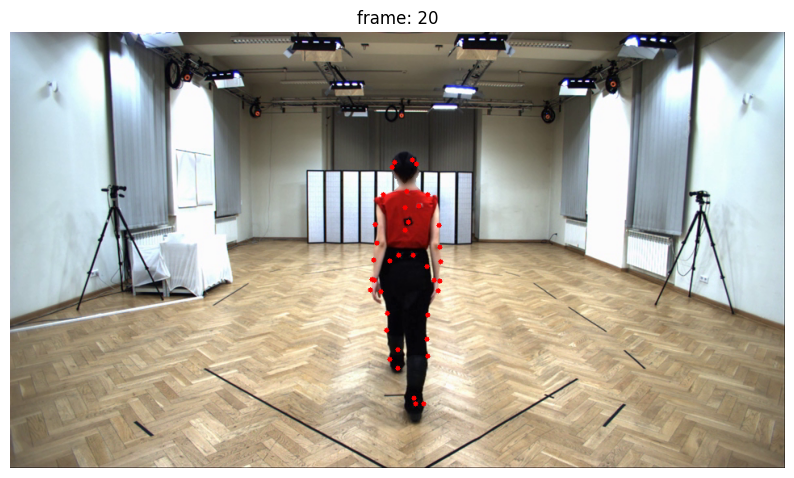

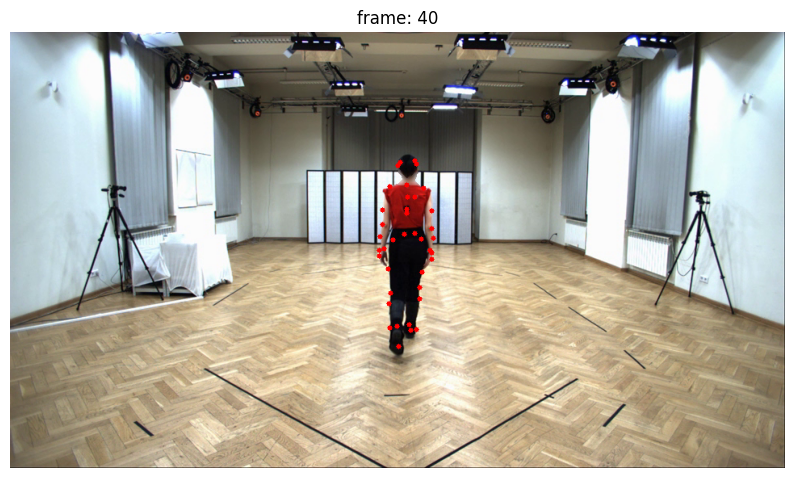

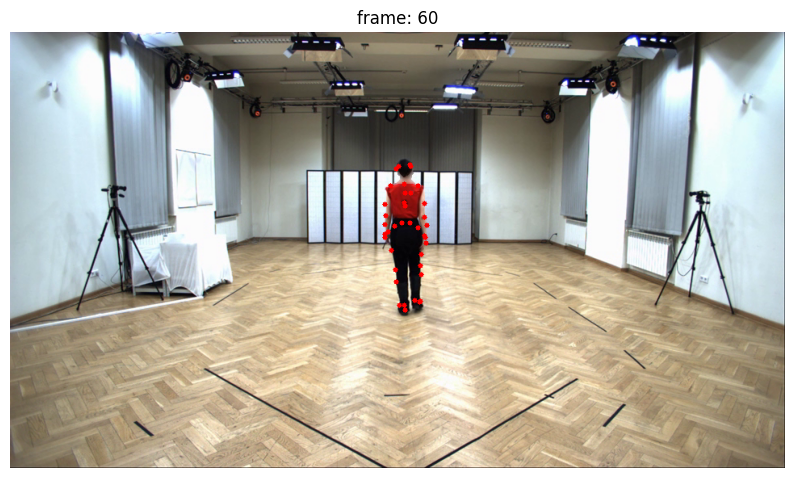

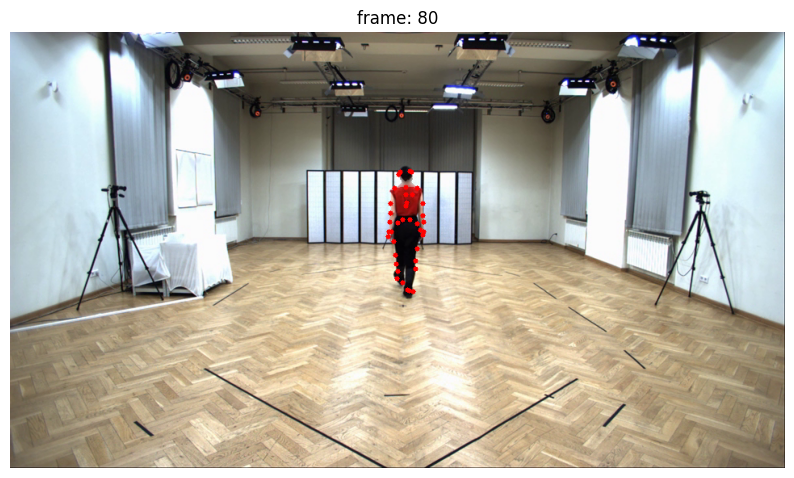

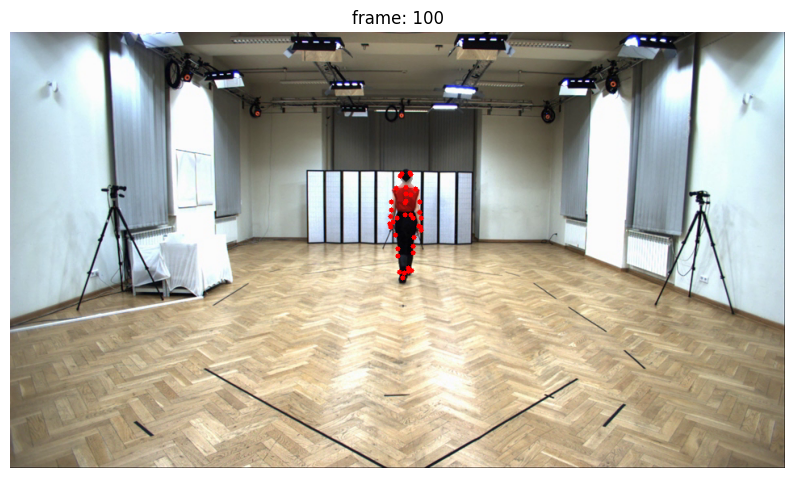

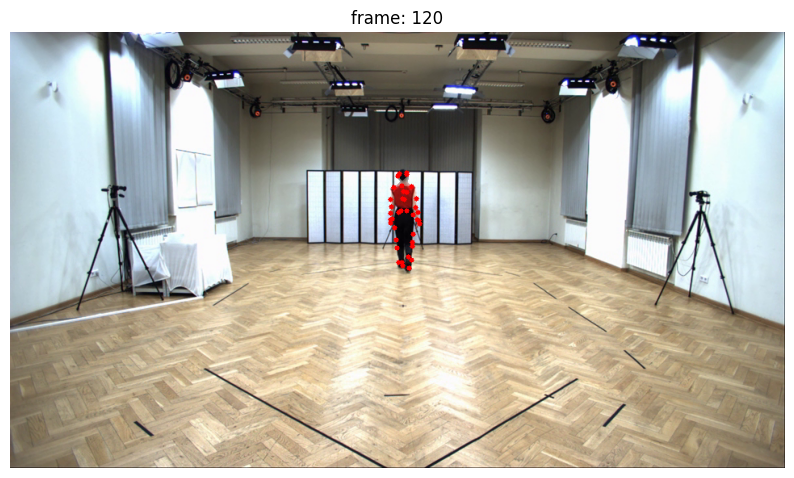

In [90]:
visualize_frame_from_video('p1s1', 2)